{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

* Resample time series data from hourly to daily, monthly, or yearly using **pandas**.

</div>


## Resample Time Series Data Using Pandas Dataframes

Often you need to summarize or aggregate time series data by a new time period. For instance, you may want to summarize hourly data to provide a daily maximum value. 

This process of changing the time period that data are summarized for is often called resampling. 

Lucky for you, there is a nice `resample()` method for **pandas** dataframes that have a `datetime` index.

On this page, you will learn how to use this `resample()` method to aggregate time series data by a new time period (e.g. daily to monthly).  


### Import Packages and Get Data

You will use the precipitation data from the <a href="https://www.ncdc.noaa.gov/cdo-web/search" target ="_blank">National Centers for Environmental Information (formerly National Climate Data Center) Cooperative Observer Network (COOP)</a> that you used previously in this chapter. 

This time, however, you will use the hourly data that was not aggregated to a daily sum: 

`805333-precip-daily-1948-2013.csv` 

This dataset contains the precipitation values collected hourly from the COOP station 050843 in Boulder, CO for January 1, 1948 through December 31, 2013. This means that there are sometimes multiple values collected for each day if it happened to rain throughout the day. 

Before using the data, consider a few things about how it was collected: 
1. The data were collected over several decades, and the data were not always collected consistently.
2. The data are not cleaned. You may find heading names that are not meaningful, and other issues with the data that need to be explored.

To begin, import the necessary packages to work with **pandas** dataframe and download data. 

You will continue to work with modules from **pandas** and **matplotlib** to plot dates more efficiently and with <a href="https://seaborn.pydata.org/introduction.html" target="_blank">**seaborn**</a> to make more attractive plots. 

In [1]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import earthpy as et

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

In [2]:
# Download the data
data = et.data.get_data('colorado-flood')

In [3]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Define relative path to file with hourly precip
file_path = os.path.join("data", "colorado-flood",
                         "precipitation",
                         "805325-precip-daily-2003-2013.csv")

Just as before, when you import the file to a **pandas** dataframe, be sure to specify the:
* no data values using the parameter `na_values`
* date column using the parameter `parse_dates`
* datetime index using the parameter `index_col`

In [4]:
# Import data using datetime and no data value
precip_2003_2013_hourly = pd.read_csv(file_path,
                                      parse_dates=['DATE'],
                                      index_col=['DATE'],
                                      na_values=['999.99'])

# View first few rows
precip_2003_2013_hourly.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,HPCP,Measurement Flag,Quality Flag
DATE,,,,,,,,
2003-01-01 01:00:00,COOP:050843,BOULDER 2 CO US,1650.5,40.03389,-105.28111,0.0,g,
2003-02-01 01:00:00,COOP:050843,BOULDER 2 CO US,1650.5,40.03389,-105.28111,0.0,g,
2003-02-02 19:00:00,COOP:050843,BOULDER 2 CO US,1650.5,40.03389,-105.28111,0.2,,
2003-02-02 22:00:00,COOP:050843,BOULDER 2 CO US,1650.5,40.03389,-105.28111,0.1,,
2003-02-03 02:00:00,COOP:050843,BOULDER 2 CO US,1650.5,40.03389,-105.28111,0.1,,


### About the Precipitation Data

The structure of the data is similar to what you saw in previous lessons. The `HPCP` column contains the total precipitation given in inches, recorded for the hour ending at the time specified by `DATE`. 

There is a designated missing data value of `999.99`. Note that if there is no precipitation recorded in a particular hour, then no value is recorded.

Additional information about the data, known as metadata, is available in the
<a href="https://ndownloader.figshare.com/files/7283453">PRECIP_HLY_documentation.pdf</a>.

Note, as of Sept. 2016, there is a mismatch in the data downloaded and the documentation. The differences are in the units and corresponding no data value: 999.99 for inches or 25399.75 for millimeters.

Once again, explore the data before you begin to work with it.

In [5]:
# View dataframe info
precip_2003_2013_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1840 entries, 2003-01-01 01:00:00 to 2013-12-31 00:00:00
Data columns (total 8 columns):
STATION             1840 non-null object
STATION_NAME        1840 non-null object
ELEVATION           1840 non-null float64
LATITUDE            1840 non-null float64
LONGITUDE           1840 non-null float64
HPCP                1746 non-null float64
Measurement Flag    1840 non-null object
Quality Flag        1840 non-null object
dtypes: float64(4), object(4)
memory usage: 129.4+ KB


In [6]:
# View summary statistics
precip_2003_2013_hourly.describe()

,ELEVATION,LATITUDE,LONGITUDE,HPCP
count,1840.0,1840.000000,1840.000000,1746.000000
mean,1650.5,40.033851,-105.281106,0.111856
std,0.0,0.000045,0.000005,0.093222
min,1650.5,40.033800,-105.281110,0.000000
25%,1650.5,40.033800,-105.281110,0.100000
50%,1650.5,40.033890,-105.281110,0.100000
75%,1650.5,40.033890,-105.281100,0.100000
max,1650.5,40.033890,-105.281100,2.200000


In [7]:
# View index values of dataframe
precip_2003_2013_hourly.index

DatetimeIndex(['2003-01-01 01:00:00', '2003-02-01 01:00:00',
               '2003-02-02 19:00:00', '2003-02-02 22:00:00',
               '2003-02-03 02:00:00', '2003-02-05 02:00:00',
               '2003-02-05 08:00:00', '2003-02-06 00:00:00',
               '2003-02-07 12:00:00', '2003-02-10 13:00:00',
               ...
               '2013-12-01 01:00:00', '2013-12-03 20:00:00',
               '2013-12-04 03:00:00', '2013-12-04 06:00:00',
               '2013-12-04 09:00:00', '2013-12-22 01:00:00',
               '2013-12-23 00:00:00', '2013-12-23 02:00:00',
               '2013-12-29 01:00:00', '2013-12-31 00:00:00'],
              dtype='datetime64[ns]', name='DATE', length=1840, freq=None)

## Plot Hourly Precipitation Data

Plot the hourly data and notice that there are often multiple records for a single day. 

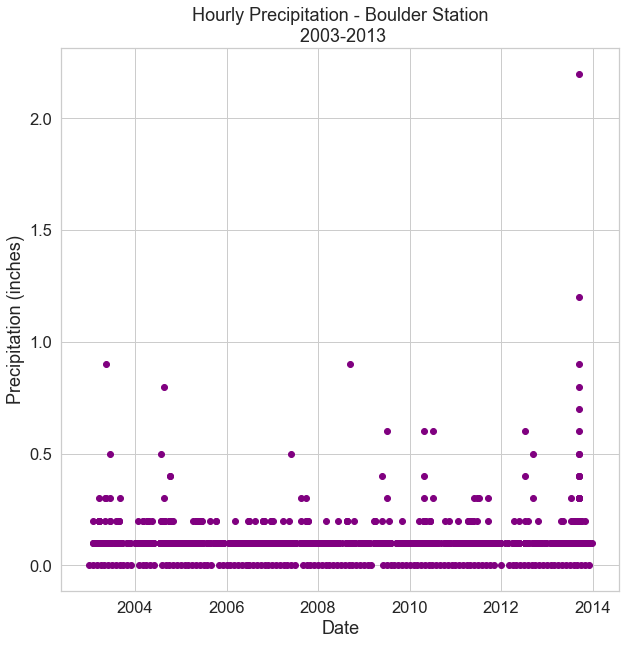

In [8]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(precip_2003_2013_hourly.index.values,
           precip_2003_2013_hourly['HPCP'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Hourly Precipitation - Boulder Station\n 2003-2013")

plt.show()

Also, notice that the plot is not displaying each individual hourly timestamp, but rather, has aggregated the x-axis labels to the year. (On the next page, you will learn how to customize these labels!)

In [9]:
# remnant from the lesson using the homework data...
# round the data 
# precip_boulder['HPCP_round'] = precip_boulder['HPCP'].apply(np.round, decimals=1)
# precip_boulder['HPCP_round'].head()

# precip_boulder.dropna(inplace= True)

# precip_boulder.head()

## Resample Hourly Data to Daily Data

To simplify your plot which has a lot of data points due to the hourly records, you can aggregate the data for each day using the `.resample()` method.

To aggregate or temporal resample the data for a time period, you can take all of the values for each day and summarize them.

In this case, you want total daily rainfall, so you will use the `resample()` method together with `.sum()`.

As previously mentioned, `resample()` is a method of **pandas** dataframes that can be used to summarize data by date or time.  The `.sum()` method will add up all values for each resampling period (e.g. for each day) to provide a summary output value for that period.

As you have already set the `DATE` column as the index, **pandas** already knows what to use for the date index.

`df.resample('D').sum()`

The `'D'` specifies that you want to aggregate, or resample, by day. 

In [10]:
# Resample to daily precip sum and save as new dataframe
precip_2003_2013_daily = precip_2003_2013_hourly.resample('D').sum()

precip_2003_2013_daily

,ELEVATION,LATITUDE,LONGITUDE,HPCP
DATE,,,,
2003-01-01,1650.5,40.03389,-105.28111,0.0
2003-01-02,0.0,0.00000,0.00000,0.0
2003-01-03,0.0,0.00000,0.00000,0.0
2003-01-04,0.0,0.00000,0.00000,0.0
2003-01-05,0.0,0.00000,0.00000,0.0
...,...,...,...,...
2013-12-27,0.0,0.00000,0.00000,0.0
2013-12-28,0.0,0.00000,0.00000,0.0
2013-12-29,1650.5,40.03380,-105.28110,0.0


Now that you have resampled the data, each HPCP value now represents a daily total or sum of all precipitation measured that day. Also notice that your `DATE` index no longer contains hourly time stamps, as you now have only one summary value or row per day. 

<div class='notice--success' markdown="1">

<i class="fa fa-star"></i> **Data Tip:** You can also resample using the syntax below if you have not already set the DATE column as an index during the import process. 

```python
# Set date column as index 
precip_hourly_index = precip_hourly.set_index('DATE')

# Resample to daily sum of precip
precip_daily = precip_hourly_index.resample('D').sum()
```
{: .notice--success}

</div>


### Plot Daily Precipitation Data

Plot the aggregated dataframe for daily total precipitation and notice that the y axis has increased in range and that there is only one data point for each day (though there are still quite a lot of points!). 

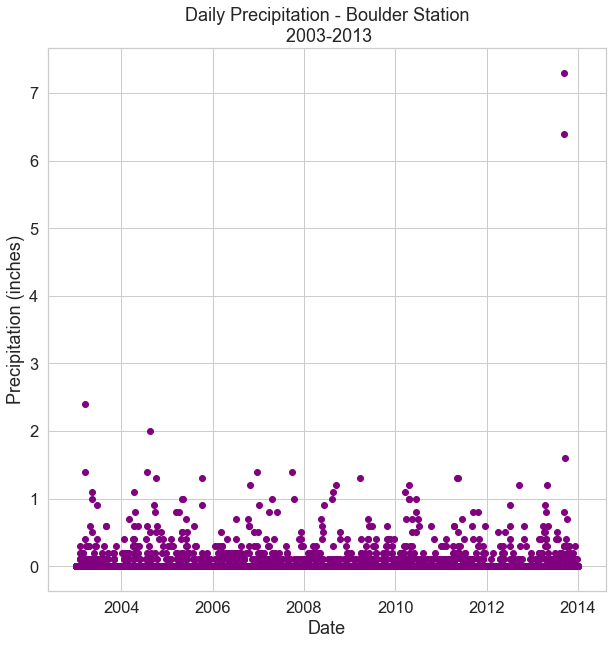

In [11]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(precip_2003_2013_daily.index.values,
           precip_2003_2013_daily['HPCP'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Daily Precipitation - Boulder Station\n 2003-2013")

plt.show()

## Resample Daily Data to Monthly Data

You can use the same syntax to resample the data again, this time from daily to monthly using:

`df.resample('M').sum()`

with `'M'` specifying that you want to aggregate, or resample, by month.

In [12]:
# Resample to monthly precip sum and save as new dataframe
precip_2003_2013_monthly = precip_2003_2013_daily.resample('M').sum()

precip_2003_2013_monthly

,ELEVATION,LATITUDE,LONGITUDE,HPCP
DATE,,,,
2003-01-31,1650.5,40.03389,-105.28111,0.0
2003-02-28,26408.0,640.54224,-1684.49776,1.4
2003-03-31,74272.5,1801.52505,-4737.64995,5.2
2003-04-30,28058.5,680.57613,-1789.77887,1.6
2003-05-31,34660.5,840.71169,-2210.90331,3.3
...,...,...,...,...
2013-08-31,14854.5,360.30420,-947.52990,1.0
2013-09-30,118836.0,2882.43360,-7580.23920,17.7
2013-10-31,31359.5,760.64220,-2000.34090,2.0


Once again, notice that now that you have resampled the data, each HPCP value now represents a monthly total and that you have only one summary value for each month.

### Plot Monthly Precipitation Data

Plot the aggregated dataframe for monthly total precipitation and notice that the y axis has again increased in range and that there is only one data point for each month. 

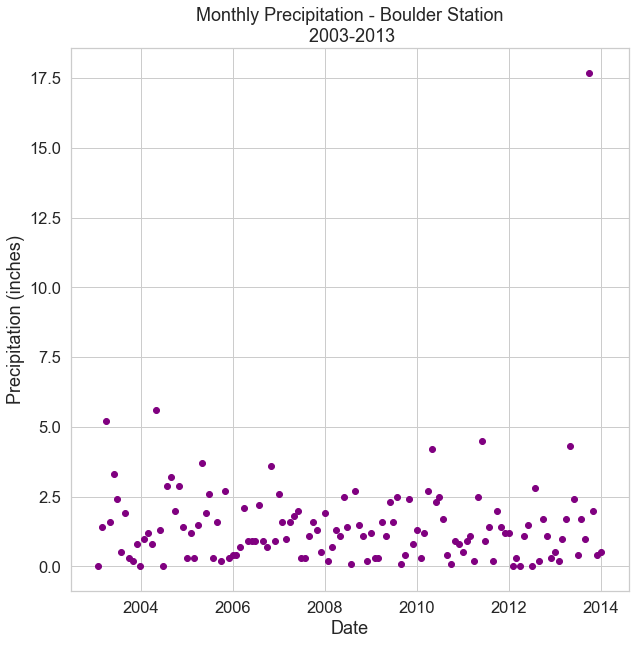

In [13]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(precip_2003_2013_monthly.index.values,
           precip_2003_2013_monthly['HPCP'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Monthly Precipitation - Boulder Station\n 2003-2013")

plt.show()

## Resample Monthly Data to Yearly Data

You can use the same syntax to resample the data one last time, this time from monthly to yearly using:

`df.resample('Y').sum()`

with `'Y'` specifying that you want to aggregate, or resample, by year.

In [14]:
# Resample to monthly precip sum and save as new dataframe
precip_2003_2013_yearly = precip_2003_2013_monthly.resample('Y').sum()

precip_2003_2013_yearly

,ELEVATION,LATITUDE,LONGITUDE,HPCP
DATE,,,,
2003-12-31,255827.5,6205.25295,-16318.57205,17.6
2004-12-31,349906.0,8487.18468,-22319.59532,22.6
2005-12-31,292138.5,7085.99853,-18634.75647,16.7
2006-12-31,278934.5,6765.72741,-17792.50759,16.8
2007-12-31,259128.5,6285.32073,-16529.13427,15.0
2008-12-31,239322.5,5804.91405,-15265.76095,14.0
2009-12-31,250876.0,6085.13949,-16002.72741,14.7
2010-12-31,272332.5,6605.57700,-17371.38150,17.6
2011-12-31,300391.0,7286.15160,-19161.16020,17.5


After the resample, each HPCP value now represents a yearly total, and there is now only one summary value for each year.

Notice that the dates have also been updated in the dataframe as the last day of each year (e.g. 2013-12-31). This is important to note for the plot, in which the values will appear along the x axis with one value at the end of each year. 

Note that you can also resample the hourly data to a yearly timestep, without first resampling the data to a daily or monthly timestep:

```python
precip_2003_2013_yearly = precip_2003_2013_hourly.resample('Y').sum()
```

This helps to improve the efficiency of your code if you do not need the intermediate resampled timesteps (e.g. daily, monthly) for a different purpose.


### Plot Yearly Precipitation Data

To minimize your code further, you can use `precip_2003_2013_hourly.resample('Y').sum()` directly in the plot code, rather than `precip_2003_2013_yearly`, as shown below:

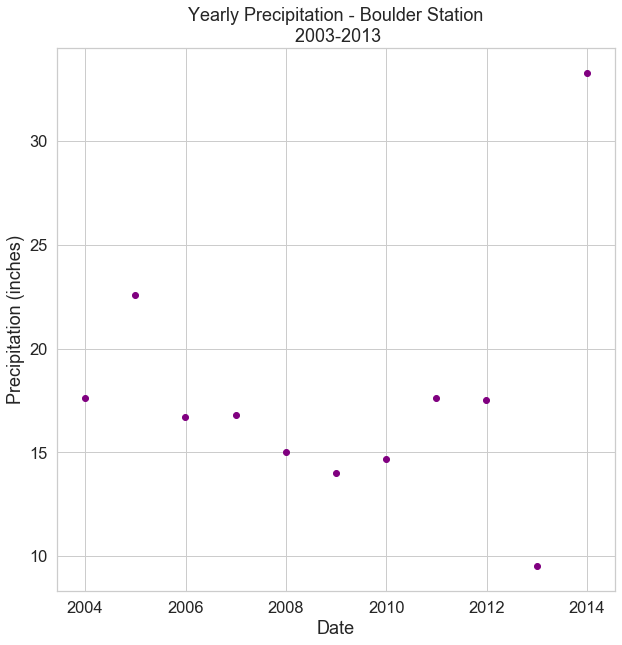

In [15]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(precip_2003_2013_hourly.resample('Y').sum().index.values,
           precip_2003_2013_hourly.resample('Y').sum()['HPCP'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Yearly Precipitation - Boulder Station\n 2003-2013")

plt.show()

### Think of New Applications and Uses of Resampling

Given what you have learned about resampling, how would change the code `df.resample('D').sum()` to resample the data to a weekly interval?

How about changing the code `df.resample('D').sum()` calculate a mean, minimum or maximum value, rather than a sum?